In [2]:
from seqseek import Chromosome, BUILD37, BUILD38
import re
import json
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
both_file = open('output_files/output_K562_distal_both_FDR_0.1.txt', 'r')
both = both_file.readlines()
depleted_file = open('output_files/output_K562_distal_depleted_FDR_0.1.txt', 'r')
depleted = depleted_file.readlines()
enriched_file = open('output_files/output_K562_distal_enriched_FDR_0.1.txt', 'r')
enriched = enriched_file.readlines()
nonsig_file = open('output_files/output_K562_distal_nonsig_FDR_0.1.txt', 'r')
nonsig = nonsig_file.readlines()

In [4]:
def extract_records(file):
    records = []
    for line in file:
        if line.startswith('Record'):
            records.append(line)
    return records

In [5]:
def clean_record(record):
    split = record.split("....")
    info = split[0]
    info = info[7:-1]
    info_sep = re.split(',|=', info)
    ret = {"chr":info_sep[1], "pos":info_sep[3], "ref":info_sep[5], "alt":info_sep[7][1:2]}
    return ret

In [6]:
def create_sub_mapping():
    subs = {"C>A":1, "G>T":1, "C>G":2, "G>C":2, "C>T":3, "G>A":3, "T>A":4, "A>T":4,"T>C":5, "A>G":5, "T>G":6, "A>C":6}
    return subs

In [7]:
def create_sub_mapping_rev():
    subs_rev = {1:"C>A", 2:"C>G", 3:"C>T", 4:"T>A", 5:"T>C", 6:"T>G",}
    return subs_rev

In [8]:
def create_nuc_list():
    return ['A','T', 'C', 'G']

In [9]:
def sanity_check(api_nuc, ref_nuc):
    if (api_nuc != ref_nuc):
        raise ValueError("Inconsistency between seqseek and result data")

In [10]:
def create_catagories():
    cat96 = {}
    for i in range(1,7):
        cat96[i]={}
        for nuc in create_nuc_list():
            cat96[i][nuc] = {}
            for nuc2 in create_nuc_list():
                cat96[i][nuc][nuc2]=[]
    return cat96

In [11]:
def classify_record(clean_record, catagories, sub_mapping):
    sub = clean_record["ref"] + ">" + clean_record["alt"]
    chrom = clean_record["chr"]
    pos = int(clean_record["pos"])
    if chrom != 'X' and chrom != 'Y':
        chrom = int(chrom)
#     print(Chromosome(chrom, assembly=BUILD37).sequence(pos, pos+1))
    sanity_check(clean_record["ref"], Chromosome(chrom, assembly=BUILD37).sequence(pos, pos+1) )
    five_prime = Chromosome(chrom, assembly=BUILD37).sequence(pos-1, pos) 
    three_prime = Chromosome(chrom, assembly=BUILD37).sequence(pos+1, pos+2)
#     print(five_prime, three_prime)
    catagories[sub_mapping[sub]][five_prime][three_prime].append(clean_record)

In [12]:
def pipeline(rec_data, sub_mapping):
    recs = extract_records(rec_data)
    clean_recs = []
    for rec in recs:
        clean_recs.append(clean_record(rec))
    cat96 = create_catagories()
    for cln in clean_recs:
        classify_record(cln, cat96, sub_mapping)
    return cat96

In [13]:
sub_mapping = create_sub_mapping()

In [14]:
cat96_both = pipeline(both, sub_mapping)

In [15]:
cat96_depleted = pipeline(depleted, sub_mapping)

In [16]:
cat96_enriched = pipeline(enriched, sub_mapping)

In [17]:
cat96_nonsig = pipeline(nonsig, sub_mapping)

In [18]:
with open("cat96_both.json", "w") as outfile:
    json.dump(cat96_both, outfile, indent = 4)

In [19]:
with open("cat96_depleted.json", "w") as outfile:
    json.dump(cat96_depleted, outfile, indent = 4)

In [20]:
with open("cat96_enriched.json", "w") as outfile:
    json.dump(cat96_enriched, outfile, indent = 4)

In [21]:
with open("cat96_nonsig.json", "w") as outfile:
    json.dump(cat96_nonsig, outfile, indent = 4)

In [22]:
cat96_both

{1: {'A': {'A': [{'chr': '12', 'pos': '49455237', 'ref': 'G', 'alt': 'T'},
    {'chr': 'X', 'pos': '118943260', 'ref': 'C', 'alt': 'A'},
    {'chr': '3', 'pos': '167720710', 'ref': 'G', 'alt': 'T'},
    {'chr': '16', 'pos': '71599560', 'ref': 'G', 'alt': 'T'},
    {'chr': '9', 'pos': '127273536', 'ref': 'C', 'alt': 'A'}],
   'T': [{'chr': '12', 'pos': '74565325', 'ref': 'C', 'alt': 'A'},
    {'chr': '15', 'pos': '64752291', 'ref': 'C', 'alt': 'A'},
    {'chr': '16', 'pos': '88706771', 'ref': 'C', 'alt': 'A'},
    {'chr': '5', 'pos': '96211921', 'ref': 'C', 'alt': 'A'},
    {'chr': '22', 'pos': '24336222', 'ref': 'G', 'alt': 'T'},
    {'chr': '10', 'pos': '5602215', 'ref': 'C', 'alt': 'A'}],
   'C': [{'chr': '1', 'pos': '161591487', 'ref': 'G', 'alt': 'T'},
    {'chr': '9', 'pos': '132498125', 'ref': 'C', 'alt': 'A'},
    {'chr': '14', 'pos': '101367424', 'ref': 'G', 'alt': 'T'},
    {'chr': '14', 'pos': '77240066', 'ref': 'C', 'alt': 'A'},
    {'chr': '3', 'pos': '37587271', 'ref': 'C'

In [23]:
asdf = {}
for mut in cat96_both.keys():
    if mut not in asdf.keys():
        asdf[mut] = -1
    for nuc1 in create_nuc_list():
        for nuc2 in create_nuc_list():
            asdf[mut] = len(cat96_both[mut][nuc1][nuc2])

In [24]:
def get_counts(cat96):
    counts = {}
    revmap = create_sub_mapping_rev()
    for mut in cat96.keys():
        mut_int = revmap[mut]
        if mut_int not in counts.keys():
            counts[mut_int] = {}
        for nuc1 in create_nuc_list():
            for nuc2 in create_nuc_list():
                counts[mut_int][nuc1+nuc2] = len(cat96[mut][nuc1][nuc2])
    return counts

In [25]:
both_counts = get_counts(cat96_both)

In [26]:
depleted_counts = get_counts(cat96_depleted)

In [27]:
enriched_counts = get_counts(cat96_enriched)

In [28]:
nonsig_counts = get_counts(cat96_nonsig)

In [29]:
df = pd.DataFrame(columns = ['Sub', 'Flanking Bases', 'Count'])
for sub in both_counts.keys():
    for flanks in both_counts[sub].keys():
        add = {'Sub': sub, 'Flanking Bases': flanks, 'Count': both_counts[sub][flanks]}
        df = df.append(add, ignore_index = True)

In [30]:
def create_counts_df(counts_map):
    df = pd.DataFrame(columns = ['Sub', 'Flanking Bases', 'Count'])
    for sub in counts_map.keys():
        for flanks in counts_map[sub].keys():
            add = {'Sub': sub, 'Flanking Bases': flanks, 'Count': counts_map[sub][flanks]}
            df = df.append(add, ignore_index = True)
    return df

In [31]:
def create_bars(df, filename):
    df = df.pivot( "Sub", "Flanking Bases","Count")
    df.plot(kind = "bar", width=0.9)
    plt.legend(ncol=4)
    plt.savefig(filename)
    return plt

In [32]:
bot = create_counts_df(both_counts, "cat96s/both_bars")

In [33]:
dep = create_counts_df(depleted_counts, "cat96s/depleted_bars")

In [34]:
enr = create_counts_df(enriched_counts, "cat96s/enriched_bars")

In [35]:
non = create_counts_df(nonsig_counts, "cat96s/non_bars")

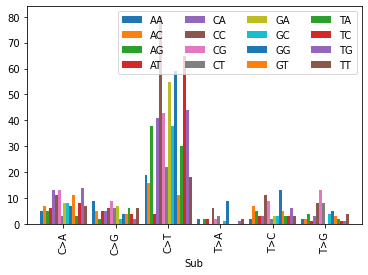

In [40]:
bot_bar = create_bars(bot)

In [45]:
bot_bar.savefig('books_read.png')

<Figure size 432x288 with 0 Axes>

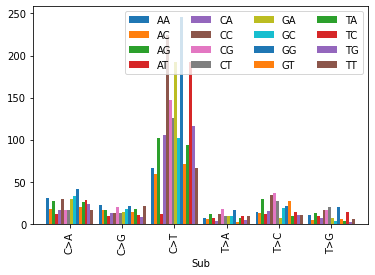

In [41]:
dep_bar = create_bars(dep)

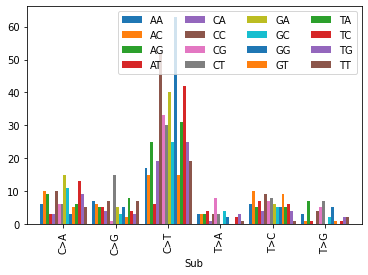

In [42]:
enr_bar = create_bars(enr)

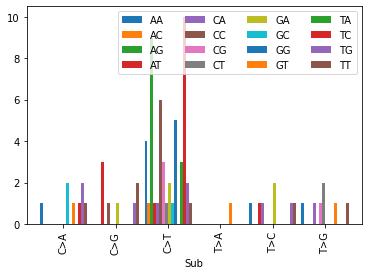

In [43]:
non_bar = create_bars(non)